In [1]:
from os.path import join, exists
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
import seaborn as sns

import h5py

from tqdm import tqdm

In [2]:
import warnings

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

In [4]:
dir_work = 'D:/mobaxterm/sungbeenpark/github/diedrichsenlab/SeqSpatialSupp_fMRI'
dir_behav = join(dir_work,'behav_data')
dir_glm = 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI/glm_2'

---

In [5]:
list_subj_S = ['S%02d'%i for i in [1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14]]
list_subj_R = ['R%02d'%i for i in [1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14]]
list_subj = list_subj_S + list_subj_R
list_subj

['S01',
 'S02',
 'S03',
 'S05',
 'S06',
 'S08',
 'S09',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'R01',
 'R02',
 'R03',
 'R05',
 'R06',
 'R08',
 'R09',
 'R10',
 'R11',
 'R12',
 'R13',
 'R14']

---

## sessions
- S
- R

Each session is consist of 8 runs with 68 trials (4 blocks, 17 trials for each block), additional run with long-ISI.
1. The starting trial states are randomly permuted.
2. 5s for each trial (preparation: 1s, movement: 3s, ISI: 1s)
3. Long resting period between blocks (~16 seconds)
4. Each run takes about 7 minutes
5. 17-, 34-, 57-, 64-th trial's ITI are $16000$

## motor sequences
- 32451
- 35124
- 13254
- 14523
## visual cues
- letter
- spatial

In [6]:
list_cue = ['Letter', 'Spatial']
list_seq = ['32451','35124','13254','14523']

---

In [7]:
subj = 'S01'
fname = glob(join(dir_behav,'ssh__%s.dat'%subj))[0]
print(fname)

D:/mobaxterm/sungbeenpark/github/diedrichsenlab/SeqSpatialSupp_fMRI\behav_data\ssh__S01.dat


In [8]:
print(subj)
df = pd.read_csv(fname, delimiter='\t')
print(df.columns.values)
df.filter(items=['BN','TN','seqType','cueP',*['response%d'%d for d in range(5)],'MT','RT','complete','points','isError','iti'])

S01
['BN' 'TN' 'seqType' 'Horizon' 'PrepTime' 'startTime' 'startTimeReal'
 'startTRReal' 'startTRtime' 'press0' 'press1' 'press2' 'press3' 'press4'
 'cueP' 'complete' 'iti' 'MT' 'RT' 'isError' 'response0' 'response1'
 'response2' 'response3' 'response4' 'pressTime0' 'pressTime1'
 'pressTime2' 'pressTime3' 'pressTime4' 'timeThreshold'
 'timeThresholdSuper' 'points' 'Gain1' 'Gain2' 'Gain3' 'Gain4' 'Gain5']


,BN,TN,seqType,cueP,response0,response1,response2,response3,response4,MT,RT,complete,points,isError,iti
0,1,1,1,35124,3,5,1,2,4,1680,566,0,1,0,1000
1,1,2,1,14523,1,4,5,2,3,1720,382,0,1,0,1000
2,1,3,0,14523,1,4,5,2,3,2056,438,0,1,0,1000
3,1,4,0,35124,3,5,1,2,4,1528,478,0,1,0,1000
4,1,5,1,32451,3,2,4,5,1,1308,408,0,1,0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,8,64,1,13254,1,3,2,5,4,1360,306,0,1,0,1000
540,8,65,0,13254,1,3,2,5,4,1870,364,0,1,0,1000
541,8,66,1,35124,3,5,1,2,4,1486,412,0,1,0,1000
542,8,67,0,35124,3,5,1,2,4,1668,234,0,1,0,1000


### (point, isError)
1) (0,0): MT=0 but the response is correct up to that point.
2) (0,1): At some point, the response becomes incorrect.
3) (1,0): A properly conducted trial.

In [9]:
for a in [0,1]:
    for b in [0,1]:
        cnt = len(df[(df.points==a)&(df.isError==b)].filter(items=['points','isError']))
        print('points=%d, isError=%d: %d'%(a,b,cnt))

points=0, isError=0: 11
points=0, isError=1: 33
points=1, isError=0: 500
points=1, isError=1: 0


In [10]:
## successive trials
df[(df.points==1)&(df.isError==0)].filter(items=['cueP',*['response%d'%d for d in range(5)],'MT','RT','complete','points','isError'])

,cueP,response0,response1,response2,response3,response4,MT,RT,complete,points,isError
0,35124,3,5,1,2,4,1680,566,0,1,0
1,14523,1,4,5,2,3,1720,382,0,1,0
2,14523,1,4,5,2,3,2056,438,0,1,0
3,35124,3,5,1,2,4,1528,478,0,1,0
4,32451,3,2,4,5,1,1308,408,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
538,35124,3,5,1,2,4,1736,316,0,1,0
539,13254,1,3,2,5,4,1360,306,0,1,0
540,13254,1,3,2,5,4,1870,364,0,1,0
541,35124,3,5,1,2,4,1486,412,0,1,0


In [11]:
# df[['MT','pressTime4','pressTime0','RT']]

PrepTime(1s) + press(3s) + ITI(1s) = 5s
- $\text{MT} \neq pressTime4 - pressTime0$
- $\text{RT} = pressTime0 - 1000(PrepTime) - (4\text{ or }6)$

## 1. Repetition

|  | trial $_{t-1}$ | trial $_{t}$ |
|---------|---------|---------|
| Both-Rep| $(i,j)$ | $(i,j)$ |
| Cue-Rep | $(i,\neg j)$ | $(i,j)$ |
| Seq-Rep | $(\neg i,j)$ | $(i,j)$ |
| NRep    | $(\neg i,\neg j)$ | $(i,j)$ |

$TS=(i,j)$

$ j=0: Letter $, $ j=1: Spatial $

$ i=0: 32451 $, $ i=1: 35124 $, $i=2: 13254 $, $ i=3: 14523$

In [12]:
list_col = ['cueP','seqType']
list_cond = ['Both-Rep','Cue-Rep','Seq-Rep','NRep']

In [13]:
dg = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for subj in tqdm(list_subj):
        fname = join(dir_behav,'ssh__%s.dat'%subj)
        df = pd.read_csv(fname, delimiter='\t')
        
        df_tmp = df.filter(items=['BN','TN','iti','startTimeReal','seqType','cueP','points','RT','MT'])
        ## 다음 trial의 sequence, cue, and validation
        df_tmp['iti-1'] = df.iti.shift(1)
        df_tmp['seqType-1'] = df.seqType.shift(1)
        df_tmp['cueP-1'] = df.cueP.shift(1)
        df_tmp['points-1'] = df.points.shift(1)
        df_tmp['RT-1'] = df.RT.shift(1)
        df_tmp['MT-1'] = df.MT.shift(1)
        ## NaN행 제거
        df_tmp = df_tmp[(df_tmp.TN>1)&(df_tmp.TN<=68)]
        ## 실패한 trials 제거
        # df_tmp = df_tmp[(df_tmp.points==1)&(df_tmp['points+1']==1)]
        ## 자료형을 int형으로 변환
        df_tmp['iti-1'] = df_tmp['iti-1'].astype(int)
        df_tmp['seqType-1'] = df_tmp['seqType-1'].astype(int)
        df_tmp['cueP-1']= df_tmp['cueP-1'].astype(int)
        df_tmp['points-1']= df_tmp['points-1'].astype(int)
        df_tmp['RT-1'] = df_tmp['RT-1'].astype(int)
        df_tmp['MT-1'] = df_tmp['MT-1'].astype(int)
        ## iti-1 > 1000인 행 제거
        df_tmp = df_tmp[df_tmp['iti-1']<=1000]
        ## default condition = NRep
        df_tmp['cond'] = 'NRep'
        ## other conditions
        df_tmp.loc[(df_tmp.seqType==df_tmp['seqType-1'])&(df_tmp.cueP==df_tmp['cueP-1']),'cond'] = 'Both-Rep'
        df_tmp.loc[(df_tmp.seqType==df_tmp['seqType-1'])&(df_tmp.cueP!=df_tmp['cueP-1']),'cond'] = 'Cue-Rep'
        df_tmp.loc[(df_tmp.seqType!=df_tmp['seqType-1'])&(df_tmp.cueP==df_tmp['cueP-1']),'cond'] = 'Seq-Rep'
        ## subj label
        df_tmp['sess']=subj[0]
        df_tmp['subj']=subj[1:]
        df_tmp['hue'] = ['%s_%s'%(seq,ses) for seq,ses in zip(df_tmp['seqType'],df_tmp['sess'])]
        ## 수행한 total trial number
        df_tmp['trial']=(df_tmp.BN-1)*68+df_tmp.TN
        
        dg = pd.concat([dg,df_tmp])
dg

100%|██████████| 24/24 [00:00<00:00, 90.55it/s]


,BN,TN,iti,startTimeReal,seqType,cueP,points,RT,MT,iti-1,seqType-1,cueP-1,points-1,RT-1,MT-1,cond,sess,subj,hue,trial
1,1,2,1000,13030.012,1,14523,1,382,1720,1000,1,35124,1,566,1680,Cue-Rep,S,01,1_S,2
2,1,3,1000,18030.027,0,14523,1,438,2056,1000,1,14523,1,382,1720,Seq-Rep,S,01,0_S,3
3,1,4,1000,23030.014,0,35124,1,478,1528,1000,0,14523,1,438,2056,Cue-Rep,S,01,0_S,4
4,1,5,1000,28030.000,1,32451,1,408,1308,1000,0,35124,1,478,1528,NRep,S,01,1_S,5
5,1,6,1000,33030.005,0,35124,1,446,1776,1000,1,32451,1,408,1308,NRep,S,01,0_S,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,8,64,1000,368020.026,0,13254,1,346,1022,1000,0,14523,1,348,1010,Cue-Rep,R,14,0_R,540
540,8,65,1000,373020.036,0,32451,1,366,1054,1000,0,13254,1,346,1022,Cue-Rep,R,14,0_R,541
541,8,66,1000,378020.031,0,14523,1,526,1014,1000,0,32451,1,366,1054,Cue-Rep,R,14,0_R,542
542,8,67,1000,383020.040,0,32451,1,328,1028,1000,0,14523,1,526,1014,Cue-Rep,R,14,0_R,543


In [14]:
## invalid trial들은 제거 후 평균
dg_groupby = dg[(dg.points==1)&(dg['points-1']==1)].groupby(['seqType','cond','sess','subj','hue'])[['MT','RT','MT-1','RT-1']].mean().reset_index()
dg_groupby

,seqType,cond,sess,subj,hue,MT,RT,MT-1,RT-1
0,0,Both-Rep,R,01,0_R,1480.800000,368.000000,1483.666667,372.733333
1,0,Both-Rep,R,02,0_R,1258.838710,405.161290,1252.967742,367.225806
2,0,Both-Rep,R,03,0_R,1246.551724,394.482759,1232.896552,408.413793
3,0,Both-Rep,R,05,0_R,1279.000000,404.187500,1253.187500,437.062500
4,0,Both-Rep,R,06,0_R,1351.500000,656.000000,1329.187500,655.625000
...,...,...,...,...,...,...,...,...,...
187,1,Seq-Rep,S,10,1_S,1140.285714,455.428571,1072.571429,506.214286
188,1,Seq-Rep,S,11,1_S,604.000000,462.133333,624.800000,489.466667
189,1,Seq-Rep,S,12,1_S,1242.322581,502.387097,1282.129032,520.322581
190,1,Seq-Rep,S,13,1_S,1200.275862,627.724138,1260.758621,622.551724


In [27]:
palette = ['#26495c','#c4a35a','#c66b3d','#c4c4cc']

MT
S
Both-Rep
t(11)=1.0142, nsp=0.3323 -> nsp_correct=2.6583
Cue-Rep
t(11)=2.3715, *p=0.0371 -> nsp_correct=0.2964
Seq-Rep
t(11)=0.6173, nsp=0.5496 -> nsp_correct=4.3966
NRep
t(11)=1.7392, nsp=0.1099 -> nsp_correct=0.8790

R
Both-Rep
t(11)=2.3506, *p=0.0384 -> nsp_correct=0.3076
Cue-Rep
t(11)=2.6546, *p=0.0224 -> nsp_correct=0.1792
Seq-Rep
t(11)=1.5910, nsp=0.1399 -> nsp_correct=1.1194
NRep
t(11)=4.6743, ***p=0.0007 -> **p_correct=0.0054

RT


D:\mobaxterm\slash\tmp\ipykernel_30960\1716142899.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)
D:\mobaxterm\slash\tmp\ipykernel_30960\1716142899.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)


S
Both-Rep
t(11)=2.8615, *p=0.0155 -> nsp_correct=0.1238
Cue-Rep
t(11)=3.2340, **p=0.0080 -> nsp_correct=0.0637
Seq-Rep
t(11)=1.1648, nsp=0.2687 -> nsp_correct=2.1499
NRep
t(11)=0.8116, nsp=0.4342 -> nsp_correct=3.4738

R
Both-Rep
t(11)=1.2260, nsp=0.2458 -> nsp_correct=1.9664
Cue-Rep
t(11)=2.2820, *p=0.0434 -> nsp_correct=0.3471
Seq-Rep
t(11)=0.3820, nsp=0.7098 -> nsp_correct=5.6780
NRep
t(11)=-1.1924, nsp=0.2582 -> nsp_correct=2.0656



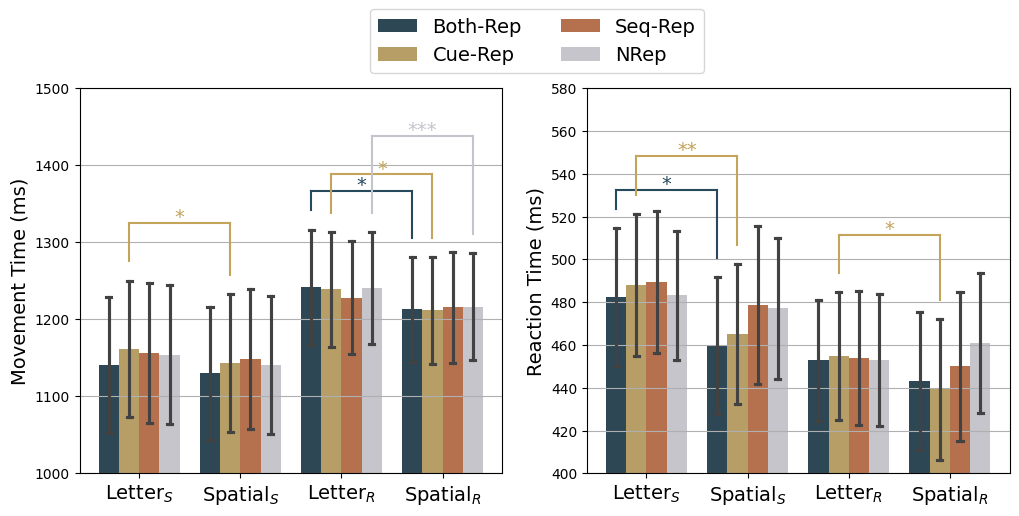

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

for ii, feature in enumerate(['MT','RT']):
    print(feature)
    ax = axs[ii]
    g = sns.barplot(
        data=dg_groupby,
        x='hue', order=['0_S','1_S','0_R','1_R'],
        y=feature, estimator='mean',
        hue='cond', hue_order=list_cond,
        capsize=0.2, errorbar='se',
        palette=palette,
        ax=ax
    )
    g.legend()
    g.grid(axis='y')
    if ii == 0:
        g.set_ylabel('Movement Time (ms)',fontsize=14)
        g.set_ylim(1000,1500)
        g.legend().remove()
    elif ii == 1:
        g.set_ylabel('Reaction Time (ms)',fontsize=14)
        g.set_ylim(400,580)
        g.legend(loc='best', bbox_to_anchor=(0.30, 1.23), ncol=2, fontsize=14)
    g.set_xlabel('')
    g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)
    # g.set_title('session %s'%sess,fontsize=16)

    ## t-test
    dy = np.diff(g.get_ylim())[0] * 0.05
    for ss, sess in enumerate(['S','R']):
        print(sess)
        for cc, cond in enumerate(list_cond):
            print(cond)
            ## Letter vs Spatial
            a = dg_groupby[(dg_groupby.sess==sess)&(dg_groupby.cond==cond)&(dg_groupby.seqType==0)][feature].astype(float)
            b = dg_groupby[(dg_groupby.sess==sess)&(dg_groupby.cond==cond)&(dg_groupby.seqType==1)][feature].astype(float)
            res = scipy.stats.ttest_rel(a,b)
            tval, pval = res
            pval_c = pval * 2 * len(list_cond)
            dof = res.df
            print('t(%d)=%.4f, %sp=%.4f -> %sp_correct=%.4f'%(dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c))
            if pval < 0.05:
                x = 2*ss + 0.2*(cc-1.5)
                y1 = a.mean() + a.sem() + dy
                y2 = b.mean() + b.sem() + dy
                # g.text(x,y1,'+')
                # g.text(x+1,y2,'+')
                yU = max(y1,y2) + dy*(cc+1)
                color = palette[cc]
                g.plot([x,x],[y1,yU],linestyle='-',color=color)
                g.plot([x+1,x+1],[y2,yU],linestyle='-',color=color)
                g.plot([x,x+1],[yU,yU],linestyle='-',color=color)
                g.text(
                    x+0.5, yU+dy*0.3,
                    convert_pvalue_to_asterisks(pval), fontsize=14, color=color,
                    ha='center', va='center',
                )
        print()

-> Spatial 에서 더 빨라야 할거 같은데? yes

In [30]:
fig.savefig(
    join(dir_work,'results/fig.behav.Rep.barplot.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

### 왜 session R에서 MT가 더 높은가?
- 단순히 더 정확히 하기 위해서 느려진 것이 아닌가?

In [18]:
palette = ['#4a83d1','#d1984a']

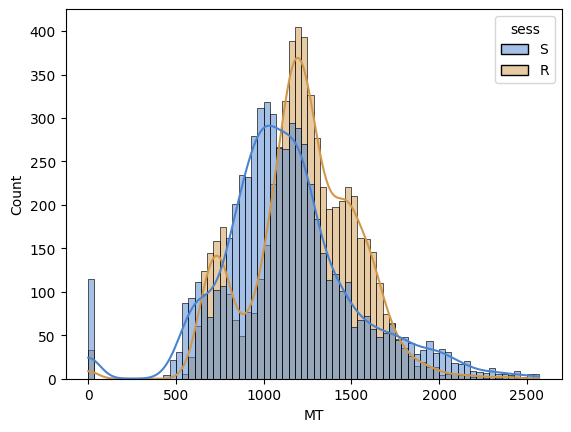

In [19]:
g = sns.histplot(
    data=dg,
    x='MT',
    hue='sess', palette=palette, kde=True,
    alpha=0.5
)
# g.legend()

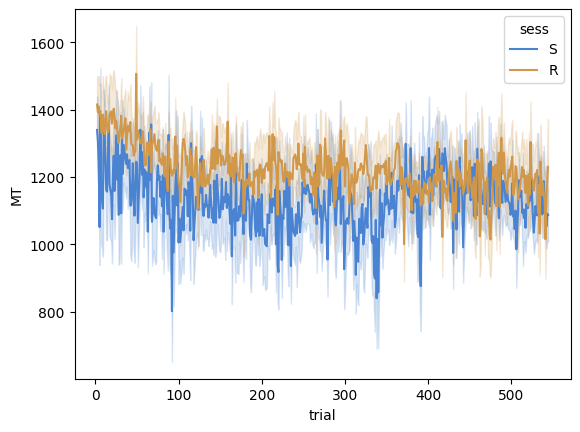

In [20]:
g = sns.lineplot(
    data=dg,
    x='trial', y='MT',
    hue='sess', palette=palette,
    errorbar='se', err_style='band'
)

-> 실험 초반에 느리게 함. 정확성을 위해서가 맞는 듯.

---

## 2. Sequence: 어떤 Seq가 어려웠나?

In [21]:
df = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for subj in list_subj:
        fname = join(dir_behav,'ssh__%s.dat'%subj)
        df_tmp = pd.read_csv(fname, delimiter='\t')
        df_tmp = df_tmp[['BN','TN','seqType','cueP','MT','RT','points','isError']]
        
        ## 각 run의 가장 마지막 trial은 제외
        # df = df[df.iti<2000]

        ## 9번째 run (long ITI)은 제거
        df_tmp = df_tmp[df_tmp.BN < 9]

        ## 성공적으로 수행한 trial들만 고려
        df_tmp = df_tmp[df_tmp.points == 1]

        df_tmp.seqType = ['Letter' if i==0 else 'Spatial' for i in df_tmp.seqType]
        df_tmp.cueP = df_tmp.cueP.astype('str')

        df_tmp['sess'] = subj[0]
        df_tmp['subj'] = subj[1:]
        # df_tmp['hue'] = ['%s_%s'%(seq,ses) for seq,ses in zip(df_tmp.seqType,df_tmp.sess)]

        df = pd.concat([df,df_tmp])
df

,BN,TN,seqType,cueP,MT,RT,points,isError,sess,subj
0,1,1,Spatial,35124,1680,566,1,0,S,01
1,1,2,Spatial,14523,1720,382,1,0,S,01
2,1,3,Letter,14523,2056,438,1,0,S,01
3,1,4,Letter,35124,1528,478,1,0,S,01
4,1,5,Spatial,32451,1308,408,1,0,S,01
...,...,...,...,...,...,...,...,...,...,...
539,8,64,Letter,13254,1022,346,1,0,R,14
540,8,65,Letter,32451,1054,366,1,0,R,14
541,8,66,Letter,14523,1014,526,1,0,R,14
542,8,67,Letter,32451,1028,328,1,0,R,14


In [22]:
df_groupby = df.groupby(['sess','subj','seqType','cueP'])[['MT','RT']].mean().reset_index()
print('n_sess * n_subj * n_cue * n_seq = %d'%(2*12*2*4))
df_groupby

n_sess * n_subj * n_cue * n_seq = 192


,sess,subj,seqType,cueP,MT,RT
0,R,01,Letter,13254,1532.969697,376.181818
1,R,01,Letter,14523,1695.114754,380.622951
2,R,01,Letter,32451,1355.250000,363.218750
3,R,01,Letter,35124,1443.939394,390.242424
4,R,01,Spatial,13254,1405.365079,337.936508
...,...,...,...,...,...,...
187,S,14,Letter,35124,938.656716,368.358209
188,S,14,Spatial,13254,937.384615,349.384615
189,S,14,Spatial,14523,958.477612,337.910448
190,S,14,Spatial,32451,974.176471,320.911765


MT
32451
t(23)=3.9670, ***p=0.0006
35124
t(23)=0.1105, nsp=0.9129
13254
t(23)=3.4324, **p=0.0023
14523
t(23)=3.1798, **p=0.0042
RT
32451
t(23)=6.2709, ****p=0.0000
35124
t(23)=2.2118, *p=0.0372
13254
t(23)=0.5552, nsp=0.5841
14523
t(23)=-0.1176, nsp=0.9074


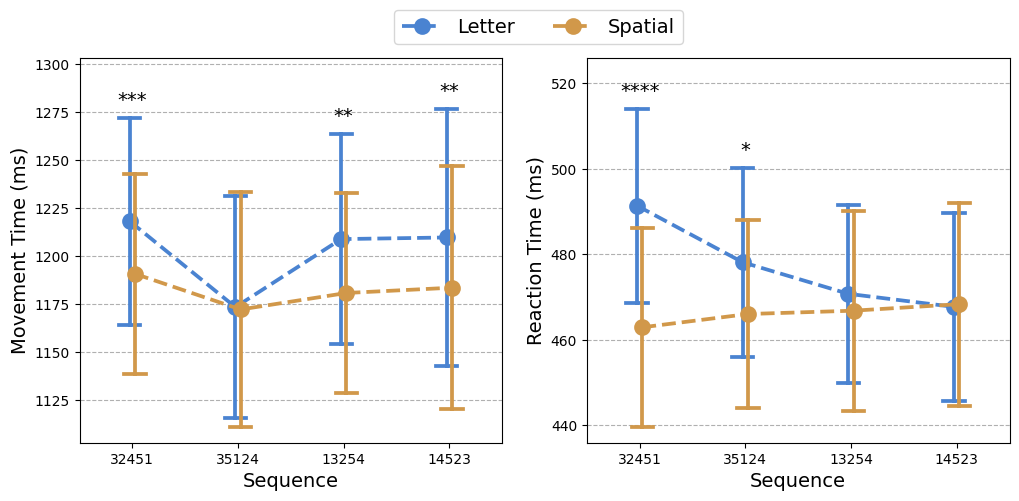

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

hue = 'seqType'
# hue = 'sess'
for ii, feature in enumerate(['MT','RT']):
    print(feature)
    ax = axs[ii]
    g = sns.pointplot(
        data=df_groupby,
        x='cueP', order=list_seq, y=feature, hue=hue,
        linestyles='--', markers=['o','o'], markersize=10, palette=palette,
        errorbar='se', capsize=0.2, dodge=True,
        ax=ax
    )
    # g = sns.barplot(
    #     data=df_groupby,
    #     x='cueP', y=feature,
    #     hue='seqType', order=list_seq, palette=palette,
    #     errorbar='se', capsize=0.2, dodge=False,
    #     ax=ax
    # )
    g.grid(axis='y', linestyle='--')
    if ii==0:
        g.legend(loc='best', bbox_to_anchor=(1.45, 1.15), ncol=2, fontsize=14)
    else:
        g.legend().remove()
    g.set_xlabel('Sequence', fontsize=14)
    ylabel = 'Movement Time (ms)' if feature=='MT' else 'Reaction Time (ms)'
    g.set_ylabel(ylabel, fontsize=14)
    ya, yb = g.get_ylim()
    dy = (yb-ya) * 0.05

    ## t-test
    for ss, seq in enumerate(list_seq):
        print(seq)
        a = df_groupby[(df_groupby.seqType=='Letter')&(df_groupby.cueP==seq)][feature].astype(float)
        b = df_groupby[(df_groupby.seqType=='Spatial')&(df_groupby.cueP==seq)][feature].astype(float)
        res = scipy.stats.ttest_rel(a,b)
        tval, pval = res
        dof = res.df
        print('t(%d)=%.4f, %sp=%.4f'%(dof,tval,convert_pvalue_to_asterisks(pval),pval))
        
        if pval < 0.05:
            x = ss # + 0.2*(cc-1.5)
            y1 = a.mean()+a.sem()
            y2 = b.mean()+b.sem()
            y = max(y1,y2) + dy
            
            g.text(
                x, y,
                convert_pvalue_to_asterisks(pval), fontsize=14, color='black',
                ha='center', va='center',
            )
    g.set_ylim(ya,yb+dy*2)

-> Spatial Cue의 경우 직관적이므로, 반응시간(RT)과 입력시간(MT) 모두 단축되었으며, sequence에 관계없이 비슷한 시간들을 나타낸다.

-> Letter: sequence에 '45'가 포함되어 있는 경우는 느린듯 (MT$\uparrow$), 마찬가지로 첫 손가락이 '3'인 경우도 반응이 느린듯 (RT$\uparrow$)

In [24]:
fig.savefig(
    join(dir_work,'results/fig.behav.sequence.pointplot.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

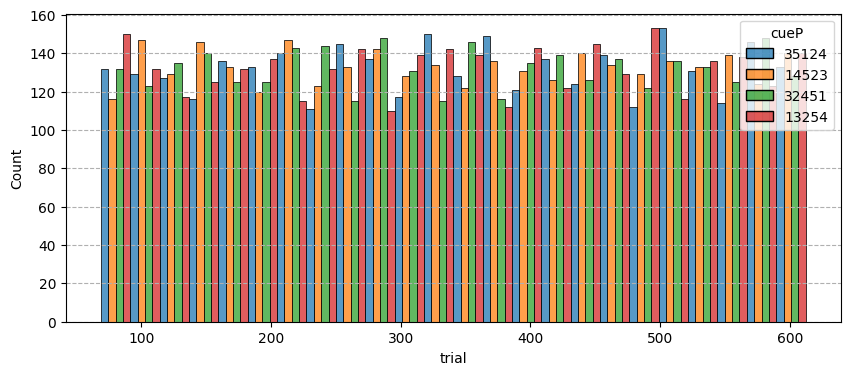

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
df['trial'] = df.BN*68 + df.TN
g = sns.histplot(
    data=df,
    x='trial', stat='count', kde=False,
    hue='cueP', multiple='dodge',
    ax=ax
)
# g.legend()
g.grid(axis='y', linestyle='--')

---